# 第4章 顧客の行動を予測する10本ノック (31~40)

In [1]:
# 下準備として，データのあるディレクトリに移動しておく
import os

DATA_ROOT_DIR = "./sample/4章/"
os.chdir(DATA_ROOT_DIR)

## ノック31 データを読み込んで確認しよう
例のごとく、まずはデータを読み込む

In [2]:
import pandas as pd
use_log = pd.read_csv("use_log.csv")
use_log.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [3]:
customer = pd.read_csv("customer_join.csv")
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

## ノック32 クラスタリングで顧客をグループ化しよう
scikit-learnを使ってクラスタリングする

In [4]:
customer_clustering = customer[["mean", "median", "max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering["cluster"] = clusters.labels_
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[3 1 0 2]


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


## ノック33 クラスタリング結果を分析しよう
クラスタの特徴を分析する．

In [6]:
customer_clustering.columns = ["月内平均値", "月内中央値", "月内最大値", "月内最小値", "会員期間", "cluster"]
customer_clustering.groupby("cluster").count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,1336,1336,1336,1336,1336
1,761,761,761,761,761
2,846,846,846,846,846
3,1249,1249,1249,1249,1249


In [7]:
customer_clustering.groupby("cluster").mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,5.522518,5.373129,8.743263,2.686377,14.831587
1,3.051243,2.885677,4.750329,1.653088,9.269382
2,8.054608,8.039598,10.009456,6.160757,7.072104
3,4.677494,4.671337,7.232986,2.153723,36.915933


## ノック34クラスタリング結果を可視化してみよう
主成分分析により2次元に次元削減し，クラスタリング結果を平面にプロットする．

In [8]:
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

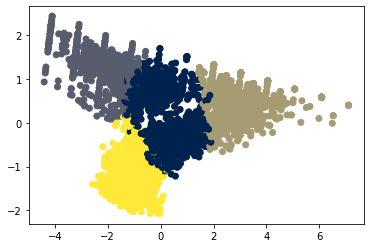

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# viridisよりcividisの方が好き． 
plt.scatter(pca_df.loc[:, 0], pca_df.loc[:, 1], cmap="cividis",  c=pca_df["cluster"])


## ノック35 クラスタリング結果をもとに退会顧客の傾向を把握しよう
継続顧客と退会顧客を比較する．

In [10]:
customer_clustering = pd.concat([customer_clustering,customer], axis=1)
customer_clustering.groupby(["cluster", "is_deleted"], as_index=False).count()[["cluster", "is_deleted", "customer_id"]]


,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,551
2,1,1,761
3,2,0,827
4,2,1,19
5,3,0,1230
6,3,1,19


In [11]:
customer_clustering.groupby(["cluster", "routine_flg"], as_index=False).count()[["cluster", "routine_flg", "customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,229
1,0,1,1107
2,1,0,496
3,1,1,265
4,2,0,52
5,2,1,794
6,3,0,2
7,3,1,1247


## ノック36 翌月の利用回数予測を行うための準備をしよう
過去6ヵ月間の利用データを用いて，翌月のデータを予想する準備をする．

In [12]:
use_log["usedate"] = pd.to_datetime(use_log["usedate"])
use_log["年月"] = use_log["usedate"].dt.strftime("%Y%m")
use_log_months = use_log.groupby(["年月", "customer_id"], as_index=False).count()
use_log_months.rename(columns={"log_id":"count"}, inplace=True)
del use_log_months["usedate"]
use_log_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [13]:
year_months = list(use_log_months["年月"].unique())
predict_data = pd.DataFrame()

for i, year_month in enumerate(year_months[6:], 6):
    predict_data_month = use_log_months.loc[use_log_months["年月"] == year_month] 
    predict_data_month.rename(columns={"count":"count_pred"}, inplace=True)

    for j in range(1, 7):
        past_data = use_log_months.loc[use_log_months["年月"] == year_months[i-j]]
        del past_data["年月"]
        past_data.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        predict_data_month = pd.merge(predict_data_month, past_data, on="customer_id", how="left")

    predict_data = pd.concat([predict_data, predict_data_month], ignore_index=True)

predict_data.head()



,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [14]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


## ノック37 特徴となる変数を付与しよう
特徴として，会員期間を追加する．

In [15]:
predict_data = pd.merge(predict_data, customer[["customer_id", "start_date"]], on="customer_id", how="left")
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [16]:
predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])

from dateutil.relativedelta import relativedelta

deltas = [relativedelta(predict_data["now_date"][i], predict_data["start_date"][i]) for i in range(len(predict_data))]
periods = [delta.years*12 + delta.months for delta in deltas]
predict_data["period"] = periods
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


## ノック38 来月の利用回数モデルを作成しよう
2018年以降に入った顧客に絞って線形貝木モデルを作成する．

In [17]:
predict_data = predict_data.loc[predict_data["start_date"] >= pd.to_datetime("20180401")]
from sklearn import linear_model
import sklearn.model_selection
model = linear_model.LinearRegression()
X = predict_data[["count_0", "count_1", "count_2", "count_3", "count_4", "count_5", "period"]]
y = predict_data["count_pred"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
model.fit(X_train, y_train)

LinearRegression()

In [18]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.5975583940462618
0.6345694105502382


## ノック39 モデルに寄与している変数を確認しよう
説明変数の計数を確認する．

In [19]:
coef = pd.DataFrame({"feature_names":X.columns, "coefficient":model.coef_})
coef

,feature_names,coefficient
0,count_0,0.310199
1,count_1,0.166564
2,count_2,0.188793
3,count_3,0.194212
4,count_4,0.096628
5,count_5,0.045187
6,period,0.082807
